Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [5]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install 'gym[all]'

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [9]:
import aerosandbox as asb
import aerosandbox.numpy as np

# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Example Airplane",
    xyz_ref=[0.5, 0, 0],        # Reference for moments
    s_ref=9,                    # Reference area
    c_ref=0.9,                  # Reference chord
    b_ref=10,                   # Reference span
    wings=[
        asb.Wing(
            name="Wing",    
            symmetric=True,             # Should this wing be mirrored across the XZ plane?
            xsecs=[                     # The wing's cross ("X") sections, or "XSecs"
                asb.WingXSec(           # Root
                    xyz_le=[0, 0, .3],  # Coordinates of the XSec's leading edge
                    chord=1,
                    twist=1,            # in degrees
                    airfoil=asb.Airfoil("sd7032"),
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.2, 5, .3],
                    chord=0.6,
                    twist=-1,
                    airfoil=asb.Airfoil("sd7037"),
                )
            ]
        ),
    ],
)

 F_g : [-1.62217029e+02 -8.71766309e-18  2.38064963e+03]
 F_b : (162.2170292039455, -8.717663093141259e-18, -2380.6496293126092)
 F_w : (-45.88754223151321, -8.717663093141259e-18, -2385.7286844018895)
 M_g : [ 1.36723965e-12  2.11672679e+02 -5.01126918e-14]
 M_b : (-1.3672396548258803e-12, 211.67267926039307, 5.0112691774018003e-14)
 M_w : (-1.3576692862856813e-12, 211.67267926039307, 1.6908478548278392e-13)
   L : 2385.7286844018895
   D : 45.88754223151321
   Y : -8.717663093141259e-18
 l_b : -1.3672396548258803e-12
 m_b : 211.67267926039307
 n_b : 5.0112691774018003e-14
  CL : 0.6924568753458691
  CD : 0.01331884229698206
  CY : -2.5302985143543257e-21
  Cl : -3.9684080818563334e-17
  Cm : 0.06826435277175741
  Cn : 1.4545190401525804e-18


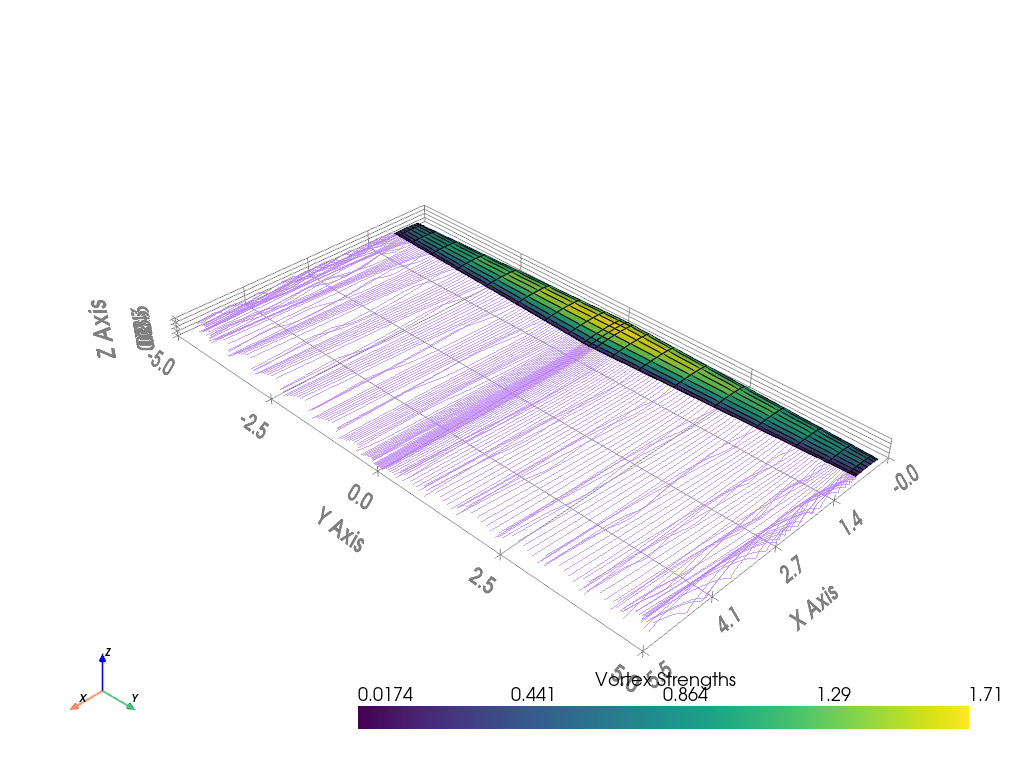

In [10]:
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=25,  # m/s
        alpha=5,  # degree
    )
)
aero = vlm.run()  # Returns a dictionary
for k, v in aero.items():
    print(f"{k.rjust(4)} : {v}")
vlm.draw(show_kwargs=dict(jupyter_backend="static"))

In [17]:
#HYPERPARAMS
dX_bounds = (-1, 1) 
dY_bounds = (-1, 1)
dZ_bounds = (-1, 1)
dChord_bounds = (-1, 1)
dTwist_bounds = (-1, 1)
KT_bounds = (0, 10)
KB_bounds = (0, 3)
N_bounds = (1, 10)
LEW_bounds = (0, 5)

numChords = 2
kulfanWeightResolution = 6

# Lower and upper bounds for each of the parameters
low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)

# Since you have 9 vectors, the action space will be:
low = np.tile(low, numChords)  # Repeating the pattern 9 times
high = np.tile(high, numChords)

print(high)

[ 1.  1.  1.  1.  1. 10. 10. 10. 10. 10. 10.  3.  3.  3.  3.  3.  3. 10.
 10.  5.  1.  1.  1.  1.  1. 10. 10. 10. 10. 10. 10.  3.  3.  3.  3.  3.
  3. 10. 10.  5.]


In [20]:
from gym import spaces
import gym
import numpy as np
	
class AeroEnv(gym.Env):
	"""Custom Environment that follows gym interface"""

	def __init__(self):
		super(AeroEnv, self).__init__()

		# Initial values for cross sections
		self.init_xyz_le = [[0, i, 0] for i in range(numChords)] #Space chords by 1 initially.
		self.init_chord = [1] * numChords  # Example values
		self.init_twist = [0] * numChords  # Example values
		self.init_upper_weights = [[0.1] * kulfanWeightResolution for _ in range(numChords)]  # Example values
		self.init_lower_weights = [[0.1] * kulfanWeightResolution for _ in range(numChords)]  # Example values
		self.init_leading_edge_weight = [0] * numChords  # Example values
		self.init_N1 = [1] * numChords  # Example values
		self.init_N2 = [1] * numChords  # Example values

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		#Initialize action space
		action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		self.action_space = action_space
		self.observation_space = spaces.Box(shape=2, # lift coefficient, drag coefficient
											dtype=np.float32)

	def step(self, action):

		for i in range(numChords):
			idx = i * len(low)

			# Apply dX, dY, dZ
			self.xsecs[i].xyz_le = [
				self.init_xyz_le[i][0] + action[idx],
				self.init_xyz_le[i][1] + action[idx + 1],
				self.init_xyz_le[i][2] + action[idx + 2]
			]

			# Apply dChord, dTwist
			self.xsecs[i].chord = self.init_chord[i] + action[idx + 3]
			self.xsecs[i].twist = self.init_twist[i] + action[idx + 4]

			# Apply KT, KB, LEW, N1, N2
			self.xsecs[i].airfoil.upper_weights = [self.init_upper_weights[i][j] + action[idx + 5 + j] for j in range(kulfanWeightResolution)]
			self.xsecs[i].airfoil.lower_weights = [self.init_lower_weights[i][j] + action[idx + 5+kulfanWeightResolution + j] for j in range(kulfanWeightResolution)]
			self.xsecs[i].airfoil.leading_edge_weight = self.init_leading_edge_weight[i] + action[idx + 5+2*kulfanWeightResolution]
			self.xsecs[i].airfoil.N1 = self.init_N1[i] + action[idx + 6+2*kulfanWeightResolution]
			self.xsecs[i].airfoil.N2 = self.init_N2[i] + action[idx + 7+2*kulfanWeightResolution]
		
		airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,             # Should this wing be mirrored across the XZ plane?
					xsecs=[self.xsecs]
				),
			],
		)

		vlm = asb.VortexLatticeMethod(
			airplane=airplane,
			op_point=asb.OperatingPoint(
				velocity=25,  # m/s
				alpha=5,  # degree
			)
		)
		aero = vlm.run()  # Returns a dictionary
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		reward=liftCoeff/dragCoeff
		return [liftCoeff, dragCoeff], reward, reward > 1.4, [liftCoeff, dragCoeff] #last array here is the info object
	
	
	def reset(self):
		return observation  # reward, done, info can't be included
	def render(self, mode='human'):
		...
	def close (self):
		...